<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.883 · Aprenentatge per reforç</p>
<p style="margin: 0; text-align:right;">Màster universitari de Ciència de Dades</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudis d'Informàtica, Multimèdia i Telecomunicació</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# Mòdul 10: exemple de Policy Gradients

En aquest _notebook_ veurem un exemple d'implementació dels algorismes de gradients de política REINFORCE amb línia de base utilitzant el mateix entorn d'OpenAI que utilitzem per a la DQN per poder comparar millor els dos mètodes.

Tant per a aquest exemple com per a les pràctiques posteriors s'utilitzarà el <i>framework</i> de __Pytorch__.

## 1. Entorn CartPole

Com en l'exemple de la DQN, usarem de nou l'entorn del joc de **CartPole**, en el qual l'objectiu és aprendre a controlar un objecte. El joc consta d'un carretó i d'un pal col·locat verticalment damunt del carretó. El pal s'aguanta únicament per gravetat, mentre que el carretó es mou a dreta i a esquerra sense parar. L'objectiu de l'agent és controlar la velocitat del carretó augmentant-la o disminuint-la amb l'objectiu d'evitar que el pal caigui. 

### 1.1 Establiment de l'entorn

En primer lloc, carregarem la llibreria __gym__ i inicialitzarem l'entorn.

In [1]:
import gym

env = gym.envs.make("CartPole-v0")

Cada entorn té definit tot el necessari perquè un agent pugui aprendre: tenim un joc que funciona d'una manera determinada i podem entrenar un agent perquè aprengui a jugar a aquest joc sense cap altra ajuda que la d'experimentar amb el joc observant, actuant i rebent recompenses. Així, l'entorn del joc ja defineix quines accions es poden prendre, quins estats poden presentar-se, en què consistirà la recompensa, etc. 

A continuació, podem visualitzar l'entorn de __CartPole__ generant un bucle sobre uns pocs episodis i, en acabar, el tanquem. 

In [2]:
#Visualitzar l'entorn
for i_episode in range(15):
    observation = env.reset()
    for t in range(100):
        env.render()  #EL RENDER NOMÉS FUNCIONA EN LOCAL: comentar línia si no s'està en local.
        print(observation)
        action = env.action_space.sample() #acció aleatòria
        observation, reward, done, info = env.step(action) #execució de l'acció triada
        if done:
            print("Episode finished after {} timesteps".format(t+1)) 
            break
env.close() #tanquem la visualització de l'entorn

[ 0.01645362  0.00139545 -0.02368032 -0.03830148]
[ 0.01648153  0.19684883 -0.02444635 -0.33836072]
[ 0.0204185   0.39230996 -0.03121356 -0.63865132]
[ 0.0282647   0.19763682 -0.04398659 -0.35595915]
[ 0.03221744  0.00316697 -0.05110577 -0.07746441]
[ 0.03228078 -0.19118652 -0.05265506  0.19866663]
[ 0.02845705  0.00464747 -0.04868173 -0.11015066]
[ 0.02855     0.20043199 -0.05088474 -0.41778628]
[ 0.03255864  0.00606667 -0.05924047 -0.14156933]
[ 0.03267997  0.20198482 -0.06207185 -0.45233755]
[ 0.03671967  0.00779308 -0.0711186  -0.17984832]
[ 0.03687553  0.20385686 -0.07471557 -0.4940918 ]
[ 0.04095267  0.00986377 -0.08459741 -0.22585995]
[ 0.04114994  0.20608648 -0.08911461 -0.54398339]
[ 0.04527167  0.40234028 -0.09999427 -0.86336099]
[ 0.05331848  0.20871144 -0.11726149 -0.60371793]
[ 0.05749271  0.40526127 -0.12933585 -0.93091397]
[ 0.06559793  0.21209964 -0.14795413 -0.68151033]
[ 0.06983992  0.01930849 -0.16158434 -0.43882304]
[ 0.07022609  0.21630436 -0.1703608  -0.77776697]


[ 0.05612002  0.19200102 -0.00092751 -0.32019618]
[ 0.05996004 -0.00310771 -0.00733144 -0.0278059 ]
[ 0.05989789 -0.19812376 -0.00788755  0.2625549 ]
[ 0.05593542 -0.00289011 -0.00263646 -0.03260538]
[ 0.05587761  0.19226955 -0.00328856 -0.32611897]
[ 0.059723   -0.00280542 -0.00981094 -0.03447493]
[ 0.0596669  -0.19778532 -0.01050044  0.25509647]
[ 0.05571119 -0.39275578 -0.00539851  0.54444897]
[ 0.04785607 -0.58780146  0.00549047  0.83542607]
[ 0.03610004 -0.78299798  0.02219899  1.12983062]
[ 0.02044008 -0.97840351  0.0447956   1.42939266]
[ 8.72014576e-04 -7.83862412e-01  7.33834538e-02  1.15103925e+00]
[-0.01480523 -0.58977069  0.09640424  0.8822406 ]
[-0.02660065 -0.7860605   0.11404905  1.20360714]
[-0.04232186 -0.98245699  0.13812119  1.52974579]
[-0.061971   -0.78924446  0.16871611  1.28316575]
[-0.07775589 -0.59662415  0.19437942  1.04770532]
Episode finished after 20 timesteps
[ 0.02540479 -0.04004038 -0.0393922   0.02741556]
[ 0.02460399  0.1556237  -0.03884389 -0.27743118

## 2. Construcció de l'algorisme de REINFORCE amb línia de base

L'algorisme REINFORCE és el principal mètode de gradients de política. En el mòdul teòric descrivíem la generalització del teorema dels gradients de política així:

$$\nabla J(\theta) \sim \left[\sum^{T-1}_{t=0} \nabla_{\theta}\log \pi_{\theta}(a_t | s_t, \theta)(G_t - b(s_t))\right]$$

on $\pi_{\theta}$ és la política, $G_t$ el retorn, i $b(s_t)$ la línia de base.

Aquesta línia de base pot ser **qualsevol funció o valor aleatori que sigui independent de l'acció** i pot ser estrictament 0, de manera que recupera l'algorisme de REINFORCE bàsic. Afegir una línia de base ens permet reduir de manera significativa la variabilitat deguda a possibles grans diferències de recompensa entre el primer i l'últim pas d'un mateix episodi.

Així, cada actualització serà proporcional al producte del retorn i el gradient de la probabilitat de prendre l'acció acollida, dividit per la probabilitat de prendre aquesta acció.

$$\theta_{t+1} = \theta + \alpha(G_t-b(S_t))\ln \pi(A_t | S_t, \theta)$$

En aquest exemple usarem com a línia de base el valor de la mitjana de les recompenses de cada episodi.

La construcció de l'algorisme es basa en el procés següent (de la mateixa manera que vam fer amb la DQN):

<ol>
    <li> Definir el model de xarxa neuronal. </li>
    <li> Definir l'agent: com ha de comportar-se. </li>
    <li> Fixar hiperparàmetres. </li>
    <li> Entrenar l'agent.  </li>
    
</ol>


Començarem important la llibreria per treballar en **Pytorch** i en altres de necessàries:

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt

### 2.1. Definició del model

El primer pas és definir la nostra xarxa neuronal. Per a aquest exemple usarem una xarxa neuronal molt senzilla amb dues capes lineals (una capa ReLU i una de sortida Softmax) i l'optimizador Adam.

També indicarem l'opció de poder treballar amb **CPU** o **CUDA**, ja que en aprenentatge per reforç la majoria dels processos solen requerir molta màquina i l'acceleració per maquinari és usualment necessària. **Aquest exemple es pot executar amb CPU**.


In [4]:
class PGReinforce(torch.nn.Module):
    
    def __init__(self, env, learning_rate=1e-3, device='cpu'):
        super(PGReinforce, self).__init__()
        self.device=device
        self.n_inputs = env.observation_space.shape[0]
        self.n_outputs = env.action_space.n
        self.learning_rate = learning_rate
        
        ### Construcció de la xarxa neuronal
        self.model = torch.nn.Sequential(
            torch.nn.Linear(self.n_inputs, 16), 
            torch.nn.ReLU(), 
            torch.nn.Linear(16, self.n_outputs),
            torch.nn.Softmax(dim=-1))
        
        self.optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        
        
        ### S'ofereix l'opció de treballar amb CUDA
        if self.device == 'cuda':
            self.model.cuda()

    #Obtenció de les probabilitats de les possibles accionis       
    def get_action_prob(self, state):
        action_probs = self.model(torch.FloatTensor(state))
        return action_probs

### 2.2. Definició de l'agent

Una vegada que tenim el model definit, només ens queda definir el comportament de l'agent, la manera com aprèn.

Com s'explica en el text teòric, en aquest cas, **no** necessitem incloure cap mètode d'exploració-explotació, ni un *buffer* de repetició d'experiències, ni una xarxa objectiu, a diferència del que ocorre amb les DQN, atès que:

<ol>
    <li> Exploració: es fa automàticament gràcies al fet que la xarxa retorna una distribució uniforme de probabilitat de les possibles accions, per la qual cosa el comportament aleatori al principi del procés ja és considerat. </li>
    <li> <i>Buffer</i>: no hi ha necessitat perquè no podem entrenar amb les dades obtingudes de la política anterior, ja que l'agent s'orienta per la política, no pels valors obtinguts de les seves accions.</li>
    <li> Xarxa objectiu: la utilitzàvem per trencar la correlació en el càlcul dels valors <i>Q</i>, però en els PG no calculem cap valor de <i>Q</i>. </li>
    
</ol>

El procés de l'agent se cenyeix, doncs, a triar accions segons la seva probabilitat, actualitzar la xarxa segons l'equació anterior i calcular la pèrdua. Aquest procés es repeteix fins que l'agent aconsegueixi la recompensa objectiu a partir de la qual es considera que ha après a jugar (en **CartPole** és 195, com s'indica en la variable `env.spec.reward_threshold`) o fins que s'esgoti el límit màxim d'episodis establert (hiperparàmetre fixat).


In [5]:
class reinforceAgent:
        
    def __init__(self, env, pgnetwork):
        
        self.env = env
        self.pgnetwork = pgnetwork
        self.nblock = 100 # bloc dels X últims episodis dels quals es calcularà la mitjana de recompensa
        self.reward_threshold = self.env.spec.reward_threshold # recompensa mitjana a partir de la qual es considera
                                                               # que l'agent ha après a jugar
        self.initialize()
        
        
    def initialize(self):
        self.batch_rewards = []
        self.batch_actions = []
        self.batch_states = []
        self.batch_counter = 1
        self.training_rewards = []
        self.mean_training_rewards = []
        self.update_loss = []
        
        
    ## Entrenament
    def train(self, gamma=0.99, max_episodes=2000, batch_size=10):
        self.gamma = gamma
        self.batch_size = batch_size
        
        episode = 0
        action_space = np.arange(self.env.action_space.n)
        training = True
        print("Training...")
        while training:
            state0 = env.reset()
            episode_states = []
            episode_rewards = []
            episode_actions = []
            gamedone = False
            
            while gamedone == False:
                # Obtenim les accions
                action_probs = self.pgnetwork.get_action_prob(state0).detach().numpy()
                action = np.random.choice(action_space, p=action_probs)
                next_state, reward, gamedone, _ = env.step(action)
                
                # Emmagatzemem les experiències que es van obtenint en aquest episodi
                episode_states.append(state0)
                episode_rewards.append(reward)
                episode_actions.append(action)
                state0 = next_state
                
                
                if gamedone:
                    episode += 1
                    # Calculem el terme del retorn menys la línia de base
                    self.batch_rewards.extend(self.discount_rewards(episode_rewards))
                    self.batch_states.extend(episode_states)
                    self.batch_actions.extend(episode_actions)
                    self.training_rewards.append(sum(episode_rewards)) # guardem les recompenses obtingudes
                    
                    
                    # Actualitzem la xarxa quan es completa la grandària del batch
                    if self.batch_counter == self.batch_size:
                        self.update(self.batch_states, self.batch_rewards, self.batch_actions)
                        self.update_loss = []
                    
                        # Reinicialitzem les variables de l'episodi
                        self.batch_rewards = []
                        self.batch_actions = []
                        self.batch_states = []
                        self.batch_counter = 1
                    
                    #Actualitzem el comptador del batch
                    self.batch_counter += 1
                    
                    # Calculem la mitjana de recompensa dels últims X episodis
                    mean_rewards = np.mean(self.training_rewards[-self.nblock:])
                    self.mean_training_rewards.append(mean_rewards)
                    
                    print("\rEpisode {:d} Mean Rewards {:.2f}\t\t".format(
                        episode, mean_rewards), end="")
                    
                    # Comprovem que encara queden episodis
                    if episode >= max_episodes:
                        training = False
                        print('\nEpisode limit reached.')
                        break
                    
                    # Acaba el joc si la mitjana de recompenses ha arribat al llindar fixat per a aquest joc  
                    if mean_rewards >= self.reward_threshold:
                        training = False
                        print('\nEnvironment solved in {} episodes!'.format(
                            episode))
                        break
                        

    def discount_rewards(self, rewards):
        discount_r = np.zeros_like(rewards)
        timesteps = range(len(rewards))
        reward_sum = 0
        for i in reversed(timesteps):  #revertim la direcció del vector per fer la suma cumulativa
            reward_sum = rewards[i] + self.gamma*reward_sum
            discount_r[i] = reward_sum
        baseline = np.mean(discount_r) # establim la mitjana de la recompensa com a línia de base
        return discount_r - baseline 
    
    
    ## Actualització                
    def update(self, batch_s, batch_r, batch_a):
        self.pgnetwork.optimizer.zero_grad()  # eliminem qualsevol gradient passat
        state_t = torch.FloatTensor(batch_s)
        reward_t = torch.FloatTensor(batch_r)       
        action_t = torch.LongTensor(batch_a)             
        loss = self.calculate_loss(state_t, action_t, reward_t) # calculem la pèrdua
        loss.backward() # fem la diferència per obtenir els gradients
        self.pgnetwork.optimizer.step() # apliquem els gradients a la xarxa neuronal
        # Guardem els valors de pèrdua
        if self.pgnetwork.device == 'cuda':
            self.update_loss.append(loss.detach().cpu().numpy())
        else:
            self.update_loss.append(loss.detach().numpy())
        
        
    ## Càlcul de la pèrdua
    # Recordatori: cada actualització és proporcional al producte del retorn i el gradient de la probabilitat
    # de prendre l'acció presa, dividit per la probabilitat de prendre aquesta acció (logaritme natural)
    def calculate_loss(self, state_t, action_t, reward_t):
        logprob = torch.log(self.pgnetwork.get_action_prob(state_t))
        selected_logprobs = reward_t * \
                        logprob[np.arange(len(action_t)), action_t]
        loss = -selected_logprobs.mean()
        return loss
   

    def plot_rewards(self):
        plt.figure(figsize=(12,8))
        plt.plot(self.training_rewards, label='Rewards')
        plt.plot(self.mean_training_rewards, label='Mean Rewards')
        plt.axhline(self.reward_threshold, color='r', label="Reward threshold")
        plt.xlabel('Episodes')
        plt.ylabel('Rewards')
        plt.legend(loc="upper left")
        plt.show()

### 2.3. Hiperparàmetres

Fixem els hiperparàmetres necessaris:

In [6]:
lr = 0.01            #Velocitat aprenentatge
MAX_EPISODES = 5000  #Nombre màxim d'episodis (l'agent ha d'aprendre abans d'arribar a aquest valor)
GAMMA = 0.99
BATCH_SIZE = 10

### 2.4. Entrenament

Carreguem el model de xarxa neuronal:

In [7]:
pgR = PGReinforce(env, learning_rate=lr)

Creem el nostre agent:

In [8]:
agent = reinforceAgent(env, pgR)

Entrenem l'agent amb els hiperparàmetres establerts:

In [9]:
agent.train(gamma=GAMMA, max_episodes=MAX_EPISODES, batch_size=BATCH_SIZE)

Training...
Episode 1457 Mean Rewards 195.14		
Environment solved in 1457 episodes!


### 2.5. Representació de l'aprenentatge de l'agent

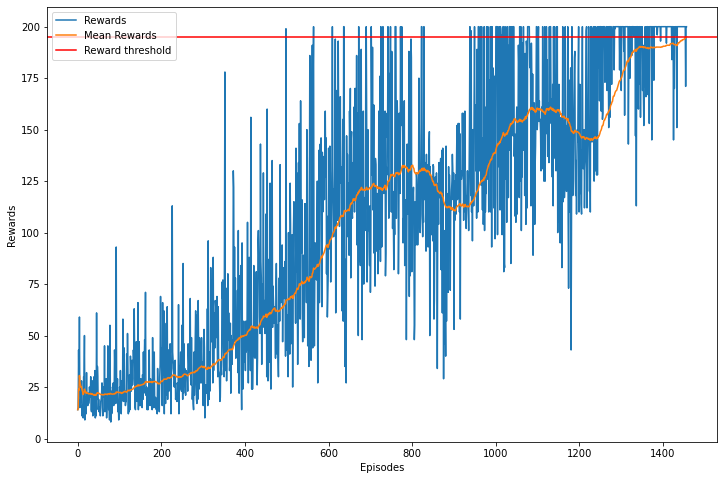

In [10]:
agent.plot_rewards()